## The goal of the projet is to predict speed from frame. This notebook describes process of loading data, creating model, training and evaluation on train.mp4 file. In approach presented in this notebook 3 frames are taken into account and model predicts speed for middle frame.

### Imports

In [1]:
import os
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, ELU, ReLU
from tensorflow.keras.optimizers import Adam

import cv2

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Check whether GPU is available

In [2]:
if tf.config.list_physical_devices('GPU'):
    print('GPU device is available')
else:
    print('No GPU available')

GPU device is available


### Paths and load data from pickle (names of files and speed for image) 

In [3]:
DATA_DIR = os.path.join('data')
PICKLE_PATH = os.path.join(DATA_DIR, 'train.pickle')
TRAIN_VID_PATH = os.path.join(DATA_DIR, 'train.mp4')

data = pickle.load(open(PICKLE_PATH, 'rb'))

### Preprocess data i.e. extract image names and stacked them in three images per sample

In [4]:
def preprocess_data(data: dict):
    images = np.array(data['x']).copy()
    speeds = data['y'].copy()
    # For current model first and last image from data set cannot be used.
    del speeds['0.png']
    del speeds[f'{images.shape[0]-1}.png']
    
    stacked_images = []
    for i in range(1, len(images)-1):
        current_batch = [images[i-1], images[i], images[i+1]]
        stacked_images.append(current_batch)
    
    return np.array(stacked_images), speeds

images, speeds = preprocess_data(data)

### Split into two datasets

In [5]:
def split_train_test(images, speeds, train_split=0.7, shuffle=True):
    """Function splits input data into train and test splits."""
    shuffled_images = images.copy()
    if shuffle:
        np.random.shuffle(shuffled_images)

    train_idx_end = int(shuffled_images.shape[0]*train_split)
    train_images = shuffled_images[:train_idx_end, :]
    test_images = shuffled_images[train_idx_end:, :]

    train_speeds = {train_images[i, 1]: speeds[train_images[i, 1]] 
                    for i in range(train_images.shape[0])}
    test_speeds = {test_images[i, 1]: speeds[test_images[i, 1]] 
                   for i in range(test_images.shape[0])}
    
    return train_images, train_speeds, test_images, test_speeds

### Split data using 0.6 - 0.2 - 0.2 split

In [6]:
# Splitting data into 
# train - 0.6
# val - 0.2
# test - 0.2
train_images, train_speeds, test_images, test_speeds = split_train_test(images, speeds, 
                                                                        train_split=0.8, shuffle=False)
train_images, train_speeds, val_images, val_speeds = split_train_test(train_images, train_speeds, 
                                                                      train_split=0.75, shuffle=False)

### Custom dataset based on *tf.keras.utils.Sequence*

In [7]:
class DatasetThreeFrames(tf.keras.utils.Sequence):
    """
    Class describing dataset for speed challenge using 3 frames. 
    Model should predict speed for middle frame.
    """
    def __init__(self, images: list, targets: dict, base_dir: str, 
                 batch_size=8, shuffle=True, transforms=None):
        """
        TODO: Docs
        """
        super().__init__()
        self.__validate_input(images, targets)
        self.__base_dir = base_dir
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__transforms = transforms
        self.__images = images
        self.__speeds = targets
        
    def __getitem__(self, idx):
        """Generate one batch of data."""
        batch_images = self.__images[idx*self.__batch_size:(idx+1)*self.__batch_size, :]
        batched_images = []
        batched_speeds = []
        for bimg in batch_images:
            prevf = cv2.imread(os.path.join(self.__base_dir, bimg[0]), cv2.IMREAD_GRAYSCALE)
            currf = cv2.imread(os.path.join(self.__base_dir, bimg[1]), cv2.IMREAD_GRAYSCALE)
            nextf = cv2.imread(os.path.join(self.__base_dir, bimg[2]), cv2.IMREAD_GRAYSCALE)
            image = np.dstack((prevf.reshape(prevf.shape + (1,)),
                               currf.reshape(currf.shape + (1,)),
                               nextf.reshape(nextf.shape + (1,)))).astype(np.float)
            image /= 255.0
            speed = self.__speeds[bimg[1]]  # model gets speed of middle image
            if self.__transforms:
                image = self.__transforms(image)
            batched_images.append(image)
            batched_speeds.append(speed)
        return np.array(batched_images), np.array(batched_speeds).reshape(-1, 1)

    def __len__(self):
        """Get number of batches."""
        return len(self.__images) // self.__batch_size
    
    def on_epoch_end(self):
        """Shuffle indexes for next epoch."""
        if self.__shuffle:
            np.random.shuffle(self.__images)
    
    @property
    def speeds(self):
        """Return target speed for every frame."""
        return self.__speeds
    
    def get_input_shape(self):
        """Get shape for grayscale image as a tuple."""
        path = os.path.join(self.__base_dir, self.__images[0, 0])
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        return img.shape + (3,)
    
    def __validate_input(self, images: list, targets: dict):
        """Validate input data."""
        if type(images) != np.ndarray or type(targets) != dict:
            raise TypeError('Invalid type of input data structures.')
            
        if images.shape[0] != len(targets.keys()):
            raise ValueError('Different length of input and output.') 

### Create train and validation datsets

In [8]:
train_ds = DatasetThreeFrames(images=train_images, targets=train_speeds, 
                              base_dir=os.path.join(DATA_DIR, 'images'), 
                              batch_size=32, shuffle=True)

val_ds = DatasetThreeFrames(images=val_images, targets=val_speeds, 
                            base_dir=os.path.join(DATA_DIR, 'images'), 
                            batch_size=32, shuffle=False) 

### Show first few samples

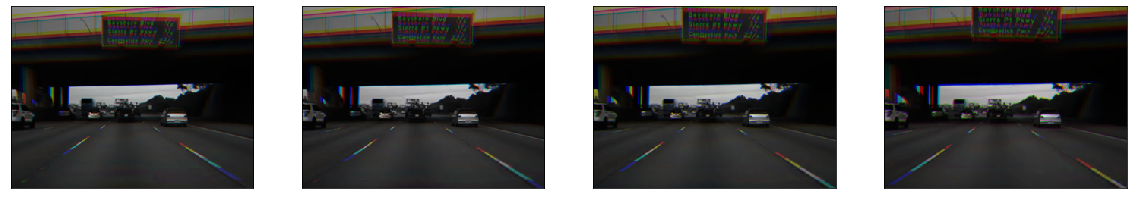

In [9]:
imgs, targets = train_ds[0]
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(imgs[i, ...])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

As you can see the samples are not shuffled. It is advised to first shuffle data before training. But for the same of gaining new knowledge, the model will be trained on this data to see the results and probable overfitting.

### Create model with optimizable parameters

In [10]:
def get_model(input_shape, params={}):
    """Get convolutional model."""
    model = Sequential(name=params.get('name', 'Speed_predictor'))
    # Conv 0
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                               input_shape=input_shape))
    model.add(ELU())

    # Conv 1
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(ELU())

    # Conv 2
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(ELU())

    # Conv 3
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(ELU())

    # Conv 4
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(ELU())

    # Flat feature maps for FC layers
    model.add(Flatten())

    # FC 5
    model.add(Dense(64))
    model.add(ELU())

    # FC 6
    model.add(Dense(32))
    model.add(ELU())

    # # FC 7
    # model.add(Dense(16))
    # model.add(ELU())

    # FC 8
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=params.get('optimizer', Adam()), 
                  loss=params.get('loss', 'mse'), 
                  metrics=params.get('metrics', ['mae']))
    return model 

In [11]:
speed_predictor = get_model(input_shape=train_ds.get_input_shape(),
                           params={'optimizer': Adam(learning_rate=0.0001)})

speed_predictor.summary()

Model: "Speed_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 160, 16)      1216      
_________________________________________________________________
elu (ELU)                    (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 32)        12832     
_________________________________________________________________
elu_1 (ELU)                  (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 40, 64)        51264     
_________________________________________________________________
elu_2 (ELU)                  (None, 30, 40, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 40, 128)   

### Training and validate

In [12]:
history = speed_predictor.fit(x=train_ds, epochs=10, verbose=1, workers=8, 
                              validation_data=val_ds
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 382 steps, validate for 127 steps
Epoch 1/10
382/382 [==============================] - 62s 162ms/step - loss: 38.9598 - mae: 4.9022 - val_loss: 230.4393 - val_mae: 13.4132
Epoch 2/10
382/382 [==============================] - 59s 154ms/step - loss: 9.0499 - mae: 2.2947 - val_loss: 156.2025 - val_mae: 10.5268
Epoch 3/10
382/382 [==============================] - 58s 151ms/step - loss: 3.8117 - mae: 1.4517 - val_loss: 160.3794 - val_mae: 10.5019
Epoch 4/10
382/382 [==============================] - 56s 147ms/step - loss: 1.4715 - mae: 0.8933 - val_loss: 173.9687 - val_mae: 10.9047
Epoch 5/10
382/382 [==============================] - 61s 159ms/step - loss: 0.7111 - mae: 0.6323 - val_loss: 196.3645 - val_mae: 11.6522
Epoch 6/10
382/382 [==============================] - 58s 153ms/step - loss: 0.3893 - mae: 0.4689 - val_loss: 195.8793 - val_mae: 11.6394
Epoch 7/10
382/382 [==============================] - 55s 145ms/step - loss: 

### Plot training metrics

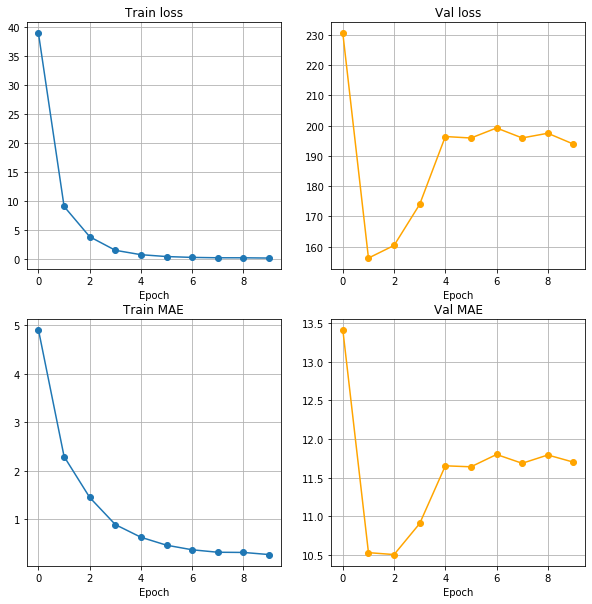

In [13]:
progress = history.history
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(progress['loss'], color='C0', marker='o', label='train loss')
ax[0, 0].grid()
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_title('Train loss')

ax[0, 1].plot(progress['val_loss'], color='orange', marker='o', label='val loss')
ax[0, 1].grid()
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_title('Val loss')

ax[1, 0].plot(progress['mae'], color='C0', marker='o', label='train mae')
ax[1, 0].grid()
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_title('Train MAE')

ax[1, 1].plot(progress['val_mae'], color='orange', marker='o', label='val mae')
ax[1, 1].grid()
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_title('Val MAE')

plt.show()

As you can see the model overfits badly because for training it received samples from the first 
part of the video so it memoried training samples.
Let's try shuffling data before training

### Split data once again but shuffle it

In [14]:
train_images, train_speeds, test_images, test_speeds = split_train_test(images, speeds, 
                                                                        train_split=0.8, shuffle=True)
train_images, train_speeds, val_images, val_speeds = split_train_test(train_images, train_speeds, 
                                                                      train_split=0.75, shuffle=True)

### Create new training and validation datasets

In [15]:
train_ds = DatasetThreeFrames(images=train_images, targets=train_speeds, 
                              base_dir=os.path.join(DATA_DIR, 'images'), 
                              batch_size=32, shuffle=True)

val_ds = DatasetThreeFrames(images=val_images, targets=val_speeds, 
                            base_dir=os.path.join(DATA_DIR, 'images'), 
                            batch_size=32, shuffle=False) 

### Show first few samples of shuffles dataset

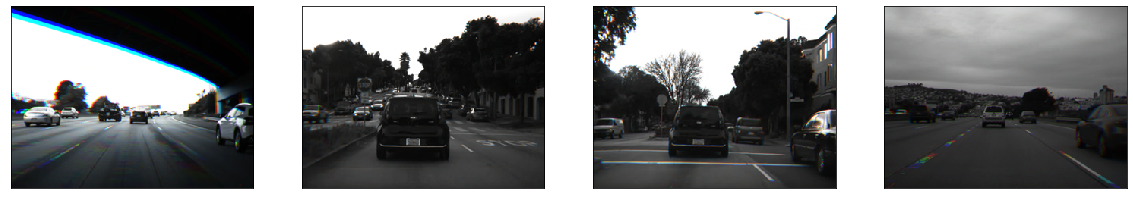

In [16]:
imgs, targets = train_ds[0]
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(imgs[i, ...])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

### Create a new model 

In [17]:
speed_predictor = get_model(input_shape=train_ds.get_input_shape(),
                            params={'optimizer': Adam(learning_rate=0.0001)})

### Train and validate

In [18]:
history = speed_predictor.fit(x=train_ds, epochs=10, verbose=1, workers=8, 
                              validation_data=val_ds
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 382 steps, validate for 127 steps
Epoch 1/10
382/382 [==============================] - 64s 167ms/step - loss: 20.0628 - mae: 3.1628 - val_loss: 4.1205 - val_mae: 1.4511
Epoch 2/10
382/382 [==============================] - 56s 147ms/step - loss: 2.5017 - mae: 1.1292 - val_loss: 1.5918 - val_mae: 0.8997
Epoch 3/10
382/382 [==============================] - 54s 141ms/step - loss: 0.9568 - mae: 0.7167 - val_loss: 0.7781 - val_mae: 0.6348
Epoch 4/10
382/382 [==============================] - 59s 154ms/step - loss: 0.4638 - mae: 0.5033 - val_loss: 0.5524 - val_mae: 0.5438
Epoch 5/10
382/382 [==============================] - 62s 162ms/step - loss: 0.3400 - mae: 0.4339 - val_loss: 0.4060 - val_mae: 0.4358
Epoch 6/10
382/382 [==============================] - 57s 149ms/step - loss: 0.2657 - mae: 0.3823 - val_loss: 0.3749 - val_mae: 0.4486
Epoch 7/10
382/382 [==============================] - 63s 164ms/step - loss: 0.2424 - mae: 0.36

### Plot training metrics

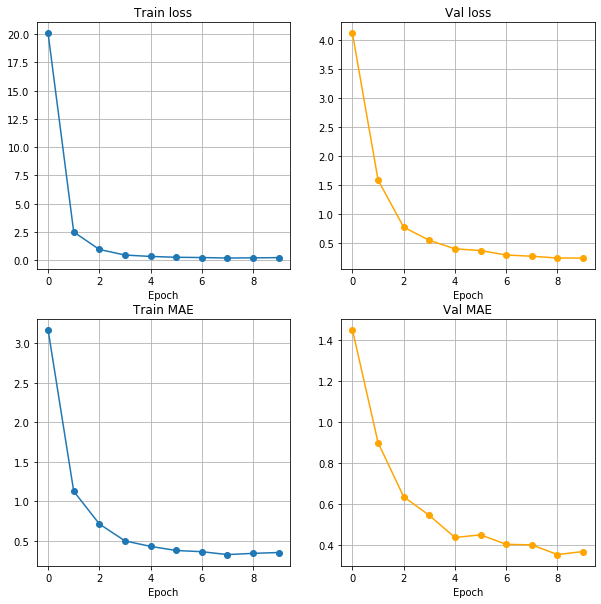

In [19]:
progress = history.history
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(progress['loss'], color='C0', marker='o', label='train loss')
ax[0, 0].grid()
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_title('Train loss')

ax[0, 1].plot(progress['val_loss'], color='orange', marker='o', label='val loss')
ax[0, 1].grid()
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_title('Val loss')

ax[1, 0].plot(progress['mae'], color='C0', marker='o', label='train mae')
ax[1, 0].grid()
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_title('Train MAE')

ax[1, 1].plot(progress['val_mae'], color='orange', marker='o', label='val mae')
ax[1, 1].grid()
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_title('Val MAE')

plt.show()

### Evaluate on test split - this should be done in the end, after hyperparameter optimization

In [20]:
# Evaluate on test split
test_ds = DatasetThreeFrames(images=test_images, targets=test_speeds, 
                             base_dir=os.path.join(DATA_DIR, 'images'), 
                             batch_size=32, shuffle=False) 
metrics = speed_predictor.evaluate(x=test_ds, verbose=1, workers=8)

print(f'Loss: {metrics[0]:0.5f}, MAE: {metrics[1]:0.5f}')

  ...
    to  
  ['...']
127/127 [==============================] - 9s 73ms/step - loss: 0.2153 - mae: 0.3498
Loss: 0.21525, MAE: 0.34983


### Conclusions
- using cv2.VideoCapture is too slow to use it when training - use only to display results on full resolution images
- too big learning rate e.g. 0.001 resulted in instability in learning - after a few epochs error erupted to a big value
- shuffling data before learning is a very important step